Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.23G/3.24G [00:28<00:00, 104MB/s] 
100% 3.24G/3.24G [00:28<00:00, 120MB/s]


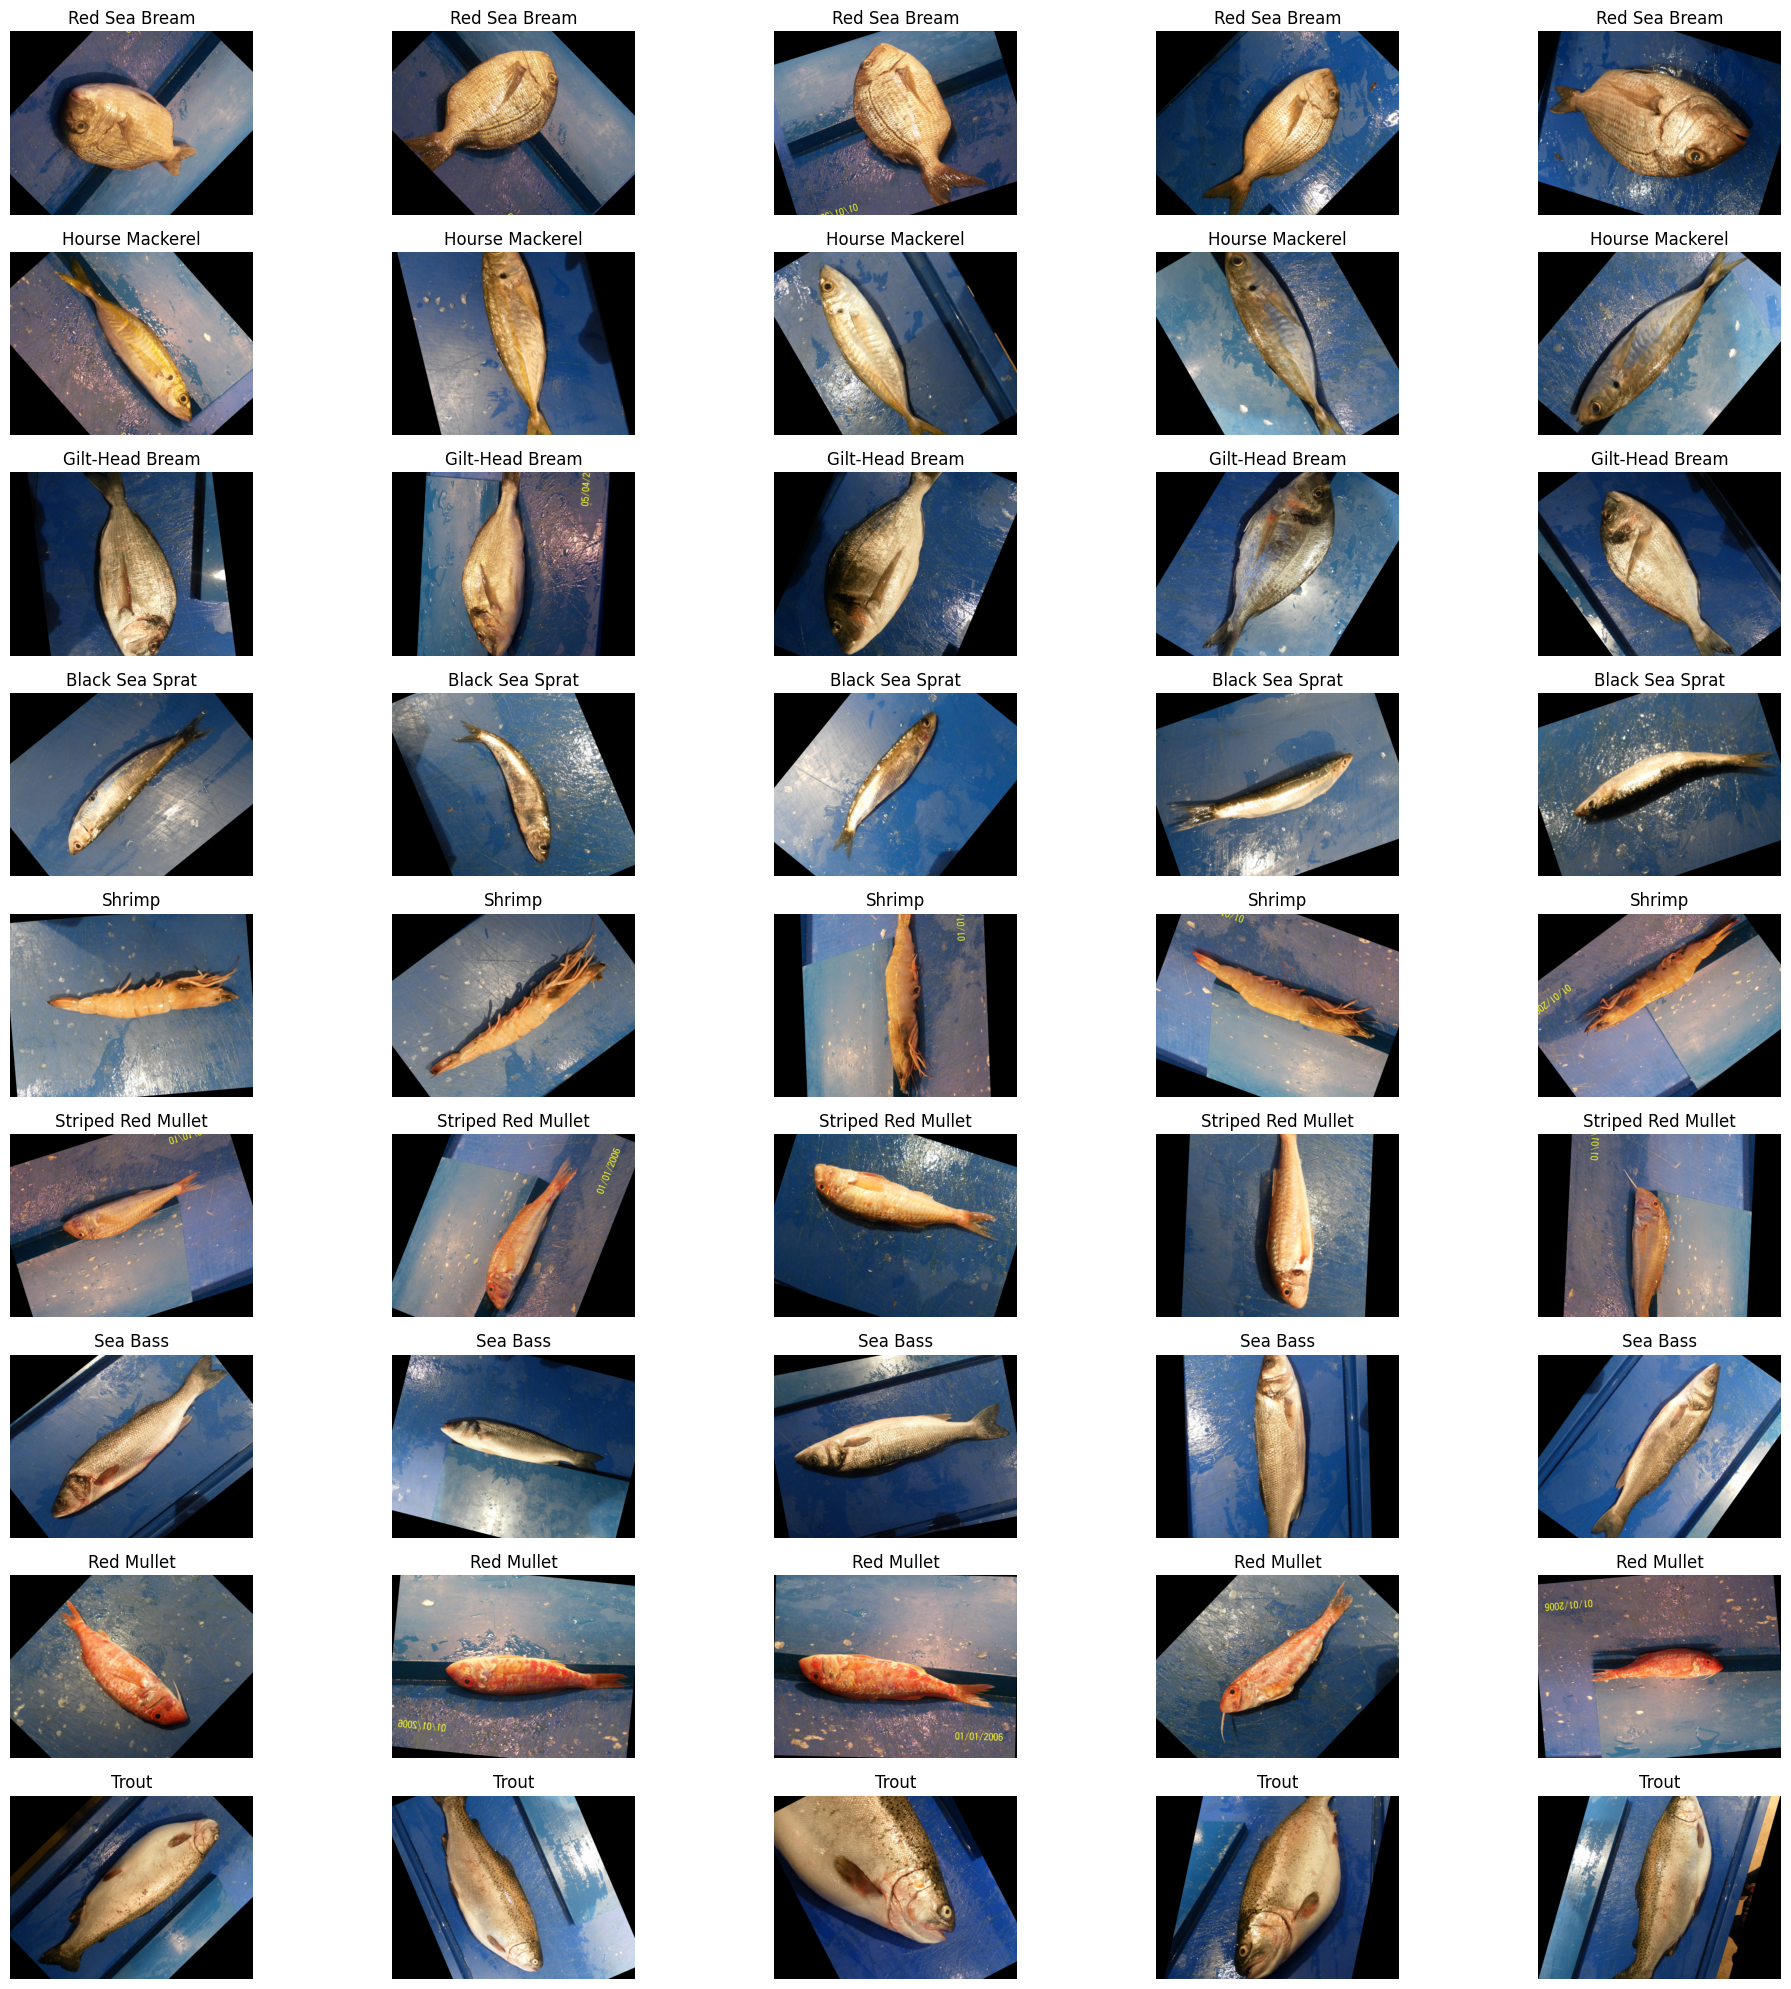

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
DIR = '/content/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]

label = []
path = []
for dirname, _, filenames in os.walk(DIR):
  for filename in filenames:
    if os.path.splitext(filename)[-1] == '.png':
      file_path = os.path.join(dirname, filename)
      class_name = dirname.split('/')[-1]
      if 'GT' not in class_name:
        path.append(file_path)
        label.append(class_name)

data_df = pd.DataFrame({'filepath': path, 'label': label})


def plot_species_images(dataframe, classes, num_images_per_class=5):
  plt.figure(figsize=(20, 20))

  for idx, species in enumerate(classes):
    species_images = dataframe[dataframe['label'] == species]['filepath'].values
    selected_images = random.sample(list(species_images), min(num_images_per_class, len(species_images)))

    for i, img_path in enumerate(selected_images):
      plt.subplot(len(classes), num_images_per_class, idx * num_images_per_class + i + 1)
      img = mpimg.imread(img_path)
      plt.imshow(img)
      plt.title(species)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

# Plot images
plot_species_images(data_df, classes)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 6300
Validation set size: 1350
Test set size: 1350


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6300 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
197/197 [==============================] - 173s 845ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0111 - val_accuracy: 0.9978
Epoch 2/5
197/197 [==============================] - 171s 870ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 0.0077 - val_accuracy: 0.9978
Epoch 3/5
197/197 [==============================] - 164s 831ms/step - loss: 0.0563 - accuracy: 0.9798 - val_loss: 0.0083 - val_accuracy: 0.9978
Epoch 4/5
197/197 [==============================] - 168s 854ms/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0064 - val_accuracy: 0.9978
Epoch 5/5
197/197 [==============================] - 161s 819ms/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0166 - val_accuracy: 0.9956


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

43/43 [==============================] - 15s 357ms/step - loss: 0.0093 - accuracy: 0.9978
Test Accuracy: 1.00


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', min_value=128, max_value=1024, step=128), activation='relu')(x)
    x = Dense(len(classes), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='tuner',
    project_name='fish_classification'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model_tuned.h5')


Reloading Tuner from tuner/fish_classification/tuner0.json


In [ ]:
!pip install tensorflow matplotlib seaborn scikit-learn umap-learn pandas

43/43 [==============================] - 16s 335ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       150
   Gilt-Head Bream       0.99      0.98      0.99       150
   Hourse Mackerel       1.00      1.00      1.00       150
        Red Mullet       1.00      1.00      1.00       150
     Red Sea Bream       0.99      1.00      1.00       150
          Sea Bass       0.99      1.00      0.99       150
            Shrimp       1.00      1.00      1.00       150
Striped Red Mullet       1.00      1.00      1.00       150
             Trout       1.00      0.99      1.00       150

          accuracy                           1.00      1350
         macro avg       1.00      1.00      1.00      1350
      weighted avg       1.00      1.00      1.00      1350

43/43 [==============================] - 15s 312ms/step


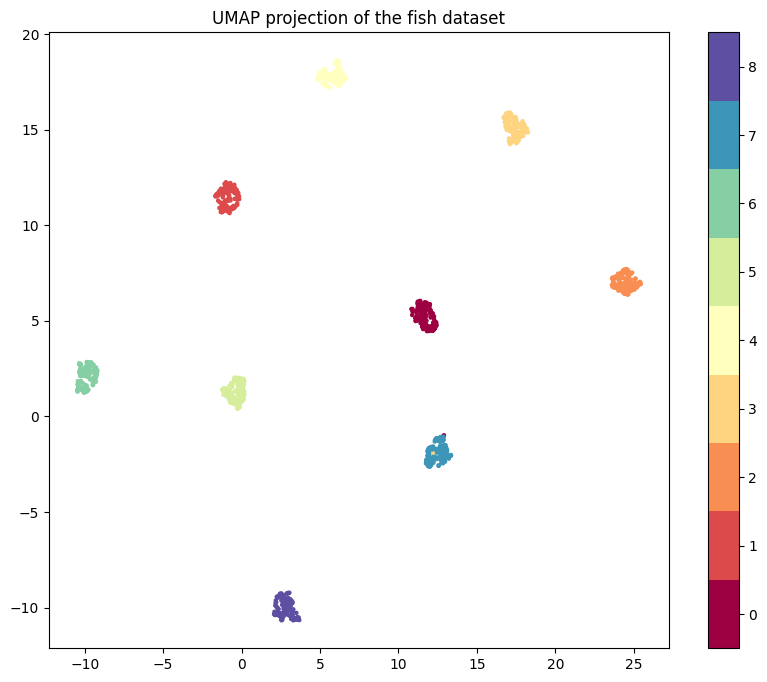

In [ ]:
from tensorflow.keras.models import load_model, Model
import umap.umap_ as umap

best_model = load_model('best_model_tuned.h5')

true_labels = test_generator.classes

predictions = best_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())


report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

# Get the features from the penultimate layer
feature_extractor = Model(inputs=best_model.input, outputs=best_model.layers[-2].output)
features = feature_extractor.predict(test_generator)

# Fit and transform the features using UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_embeddings = umap_reducer.fit_transform(features)

# Plot the UMAP embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=true_labels, cmap='Spectral', s=5)
plt.colorbar(scatter, boundaries=np.arange(len(class_labels) + 1) - 0.5).set_ticks(np.arange(len(class_labels)))
plt.title('UMAP projection of the fish dataset')
plt.show()

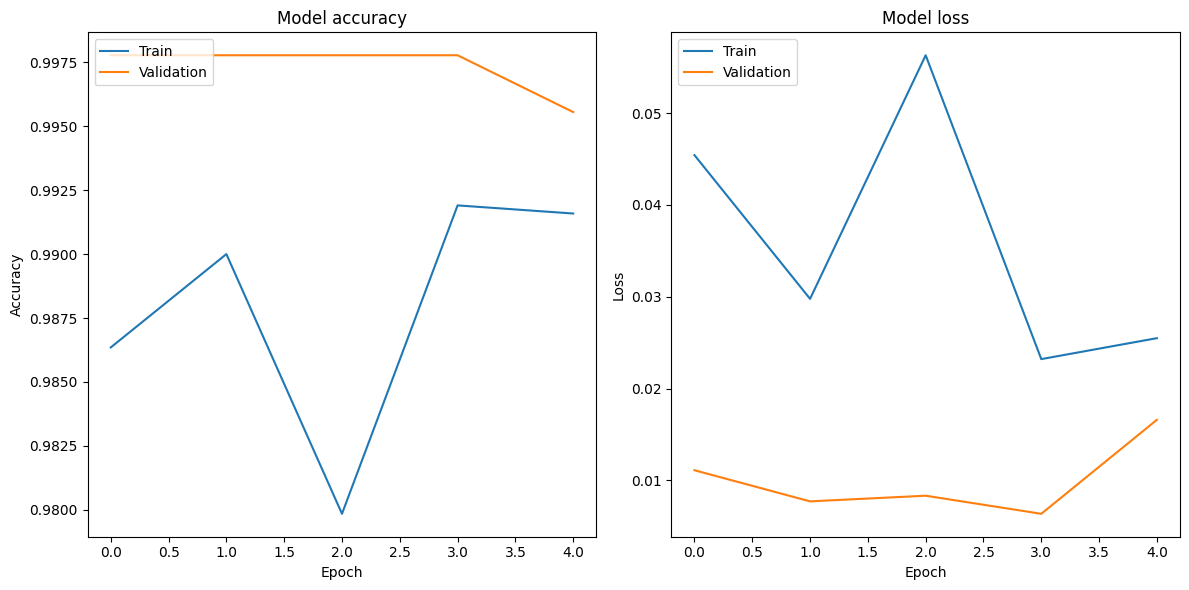

In [ ]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 6))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
!pip install plotly
